# Repetition probability as a function of PPS

## and: cue conformity as function of PPS

This notebook can be used to reproduce the figures relating psychosis-proneness to an individual's probability of repeating their previous choice. 

(c) Anna-Lena Eckert

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys, os, glob
import csv
import pingouin as pg
from scipy.stats import ttest_rel
from pathlib import Path

# settings for more convenient df inspection
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

C:\Users\annae\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [11]:
# change into folder that contains data. For optimal functioning, 
# download data folder into ChoiceHistory_Psych folder and name it "Data"
path = os.getcwd()
p = Path(path).parents[1]
file_path = str(p) + '\\Data\\Exp1_auditory\\'
os.chdir(file_path)

# read datafile
df = pd.read_csv('exp1_model1_auditory.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,sbj_id,trial,block_type,block,stimulus,target,response,cue,caps,pdi,resp_1,stim_1,pdi_zscore,caps_zscore,PPS_z,block_type_z,stimulus_z,target_z,response_z,cue_z,caps_z,pdi_z,resp_1_z,stim_1_z,block_type_z_z,stimulus_z_z,target_z_z,response_z_z,cue_z_z,caps_z_z,pdi_z_z,resp_1_z_z,stim_1_z_z
0,5e6d3324f14d262fced5bbfe,2,0,1,0.2,1,1,1,5,5,1.0,1.0,-0.644205,-0.37994,-1.024145,-0.999226,-0.882553,0.995106,1.001809,0.963416,-0.37994,-0.644205,1.002797,0.993006,-0.999226,-0.882553,0.995106,1.001809,0.963416,-0.37994,-0.644205,1.002797,0.993006
1,5e6d3324f14d262fced5bbfe,3,0,1,0.6,1,0,1,5,5,1.0,1.0,-0.644205,-0.37994,-1.024145,-0.999226,1.458884,0.995106,-0.998194,0.963416,-0.37994,-0.644205,1.002797,0.993006,-0.999226,1.458884,0.995106,-0.998194,0.963416,-0.37994,-0.644205,1.002797,0.993006
2,5e6d3324f14d262fced5bbfe,4,0,1,0.2,1,1,1,5,5,0.0,1.0,-0.644205,-0.37994,-1.024145,-0.999226,-0.882553,0.995106,1.001809,0.963416,-0.37994,-0.644205,-0.997211,0.993006,-0.999226,-0.882553,0.995106,1.001809,0.963416,-0.37994,-0.644205,-0.997211,0.993006
3,5e6d3324f14d262fced5bbfe,5,0,1,0.6,1,1,1,5,5,1.0,1.0,-0.644205,-0.37994,-1.024145,-0.999226,1.458884,0.995106,1.001809,0.963416,-0.37994,-0.644205,1.002797,0.993006,-0.999226,1.458884,0.995106,1.001809,0.963416,-0.37994,-0.644205,1.002797,0.993006
4,5e6d3324f14d262fced5bbfe,6,0,1,0.3,1,1,1,5,5,1.0,1.0,-0.644205,-0.37994,-1.024145,-0.999226,-0.297193,0.995106,1.001809,0.963416,-0.37994,-0.644205,1.002797,0.993006,-0.999226,-0.297193,0.995106,1.001809,0.963416,-0.37994,-0.644205,1.002797,0.993006


In [12]:
# create PPs score: sum of z-transformed psychosis instrument scores
df['PPS_sum'] = df['caps_z'] + df['pdi_z']

# create repetition column, if == 0: current response is NOT a repetition, elif == 1: IS repetition
df['repeat'] = np.nan

for index, row in df.iterrows(): 
    if row['response'] == row['resp_1']: 
        rep = 1
    elif row['response'] != row['resp_1']: 
        rep = 0
        
    df.at[index, 'repeat'] = rep

In [13]:
subjects = list(df['sbj_id'].unique())

# initialize result frame
df_rep = pd.DataFrame(columns=['sbj_id', 'rep_prob', 'rep_prob_rep', 'rep_prob_neut', 'PPS_sum'])

for sbj_id in subjects:
    # get overall repetition probability across blocks
    df_sbj = df[df['sbj_id']==sbj_id]
    rep_mean = df_sbj['repeat'].mean()
    pps = df_sbj['PPS_sum'].mean()
    
    # get repetition probability in repetitive blocks
    rep_rep_mean = df_sbj[df_sbj['block_type']==0]['repeat'].mean()
    
    # get repetition probability in neutral blocks
    rep_neut_mean = df_sbj[df_sbj['block_type']==1]['repeat'].mean()
    
    # put it in result df
    case = {'sbj_id':sbj_id,'rep_prob':rep_mean,'rep_prob_rep':rep_rep_mean,'rep_prob_neut':rep_neut_mean,'PPS_sum':pps}
    df_rep = df_rep.append(case, ignore_index = True)

In [14]:
# correlate mean repetition probability and PPS in repetitive blocks
corr_pps_rep = np.corrcoef(df_rep['PPS_sum'], df_rep['rep_prob_rep'])
corr_pps_rep = corr_pps_rep[0][1]

# correlate mean repetition prob and PPS in neutral blocks
corr_pps_neut = np.corrcoef(df_rep['PPS_sum'], df_rep['rep_prob_neut'])
corr_pps_neut = corr_pps_neut[0][1]

# correlate overall mean repetition prob and PPS
corr_pps = np.corrcoef(df_rep['PPS_sum'], df_rep['rep_prob'])
corr_pps = corr_pps[0][1]

In [15]:
subjects = list(df['sbj_id'].unique())
df_rep['performance'] = np.nan
df_rep.set_index('sbj_id', inplace=True)

for sbj in subjects: 
    df_sbj = df[df['sbj_id']==sbj]
    res = df_sbj.groupby(["target", "response"]).size().reset_index(name="freq")
    total_trials = res['freq'].sum()
    count_corr = res[(res['target']==0) == (res['response']==0)]['freq'].sum()
    perc_correct = (count_corr/ total_trials)*100
    
    df_rep.at[sbj, 'performance'] = perc_correct    

In [16]:
print('Mean performance: %.3f percent' % df_rep['performance'].mean())

Mean performance: 80.115 percent


In [17]:
# partial correlation between PPS and repetition probability but controlled for performance, using pingouin package 
# create partial correlation: general repetition probability 
pc_allBlocks = pg.partial_corr(data=df_rep , x='PPS_sum', y='rep_prob', covar='performance')

# partial corr: repetitive blocks. 
pc_repBlocks = pg.partial_corr(data=df_rep, x='PPS_sum', y='rep_prob_rep', covar='performance')

# partial corr: neutral blocks
pc_neutBlocks = pg.partial_corr(data=df_rep, x='PPS_sum', y='rep_prob_neut', covar='performance')

In [18]:
print('Partial correlation between PPS and repetition probability, controlled for performance.')
print('Across block types: ')
display(pc_allBlocks)
print('Only repetitive blocks: ')
display(pc_repBlocks)
print('Only neutral blocks: ')
display(pc_neutBlocks)

Partial correlation between PPS and repetition probability, controlled for performance.
Across block types: 


,n,r,CI95%,p-val
pearson,113,-0.357995,"[-0.51, -0.18]",0.000106


Only repetitive blocks: 


,n,r,CI95%,p-val
pearson,113,-0.336585,"[-0.49, -0.16]",0.000285


Only neutral blocks: 


,n,r,CI95%,p-val
pearson,113,-0.2574,"[-0.42, -0.08]",0.006147


In [19]:
# non-partialized correlations...
pc_allBlocks = pg.partial_corr(data=df_rep , x='PPS_sum', y='rep_prob')

# partial corr: repetitive blocks. 
pc_repBlocks = pg.partial_corr(data=df_rep, x='PPS_sum', y='rep_prob_rep')

# partial corr: neutral blocks
pc_neutBlocks = pg.partial_corr(data=df_rep, x='PPS_sum', y='rep_prob_neut')

In [20]:
pc_repBlocks

,n,r,CI95%,p-val
pearson,113,-0.329521,"[-0.48, -0.15]",0.000365


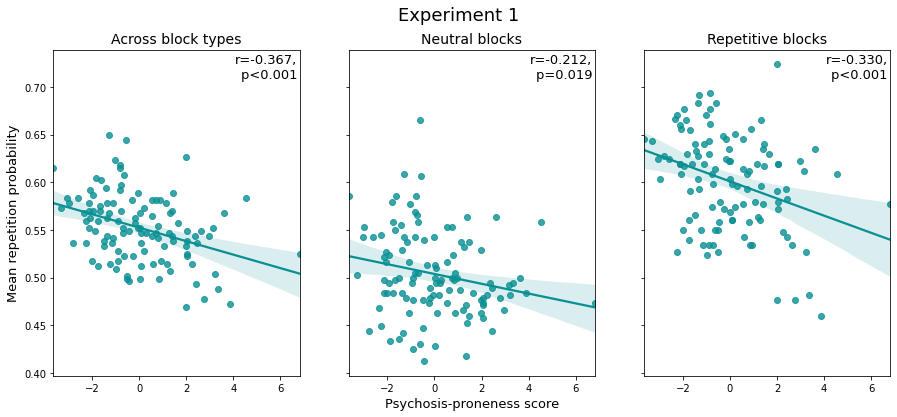

In [21]:
# create some plots next.

fig, axs = plt.subplots(1,3, sharey=True, sharex=True)
fig.set_figheight(6)
fig.set_figwidth(15)

_=plt.suptitle('Experiment 1', fontsize=18)

# plot overall mean repetition probability and PPS
_=axs[0].set_title('Across block types', fontsize=14)
_=sns.regplot(ax=axs[0], x=df_rep['PPS_sum'], y=df_rep['rep_prob'], color='#0A9094')
_=plt.text(0.99, 0.99, ('r=%.3f,\n p<0.001'%pc_allBlocks['r'].values[0]), ha='right', va='top', transform=axs[0].transAxes, fontsize=13)
_=axs[0].set_ylabel('Mean repetition probability', fontsize=13)
_=axs[0].set_xlabel(None)

# plot neutral mean repetition probability and PPS
_=axs[1].set_title('Neutral blocks', fontsize=14)
_=sns.regplot(ax=axs[1], x=df_rep['PPS_sum'], y=df_rep['rep_prob_neut'], color='#0A9094')
_=axs[1].set_ylabel(None)
_=plt.text(0.99, 0.99, ('r=%.3f,\n p=0.019'%pc_neutBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[1].transAxes, fontsize=13)
_=axs[1].set_xlabel('Psychosis-proneness score', fontsize=13)

# plot repetitive repetition probability and PPS
_=axs[2].set_title('Repetitive blocks', fontsize=14)
_=sns.regplot(ax=axs[2], x=df_rep['PPS_sum'], y=df_rep['rep_prob_rep'], color='#0A9094')
_=axs[2].set_ylabel(None)
_=plt.text(0.99, 0.99, ('r=%.3f,\n p<0.001'%pc_repBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[2].transAxes, fontsize=13)
_=axs[2].set_xlabel(None)

plt.savefig('C:\\Users\\annae\\Dropbox\\PhD\\aud_vis_paper\\svg_files\\rep_prob_exp1.svg')

,n,r,CI95%,p-val
pearson,113,-0.112005,"[-0.29, 0.07]",0.237556


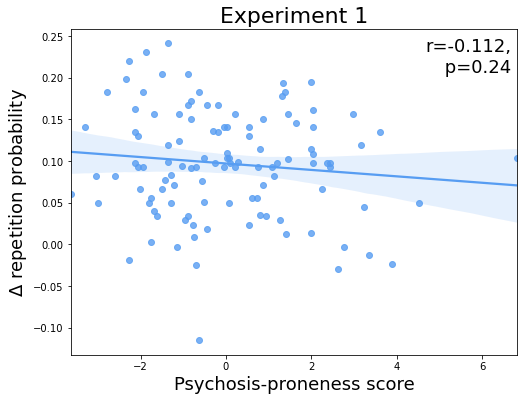

In [22]:
# Plot difference score and relate to PPS
df_rep['rep_prob_diff'] = df_rep['rep_prob_rep'] - df_rep['rep_prob_neut']
corr_pps = np.corrcoef(df_rep['PPS_sum'], df_rep['rep_prob_diff'])
corr_pps = corr_pps[0][1]
corr_pps

pc_diffBlocks = pg.partial_corr(data=df_rep, x='PPS_sum', y='rep_prob_diff')
display(pc_diffBlocks)


fig, ax = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.title('Experiment 1', fontsize=22)
_=sns.regplot(ax=ax, x=df_rep['PPS_sum'], y=df_rep['rep_prob_diff'], color='#579DF2')
_=plt.text(-0.87, 0.95, ('r=%.3f,\n p=0.24'%corr_pps), 
           ha='right', va='top', transform=axs[2].transAxes, fontsize=18)
_=ax.set_ylabel(r'$\Delta$ repetition probability', fontsize=18)
_=ax.set_xlabel(r'Psychosis-proneness score', fontsize=18)

plt.savefig('rep_prob_diff_exp1.svg')

## Cue conformity

In [23]:
# make column for cue conformity
df['cue_conf'] = np.nan

for index, row in df.iterrows(): 
    
    if row['response'] == row['cue']: 
        conf = 1
        
    elif row['response'] != row['cue']: 
        conf = 0
        
    df.at[index, 'cue_conf'] = conf
    
df_rep[['cue_conf', 'cue_conf_neut', 'cue_conf_rep']] = np.nan, np.nan, np.nan   
    
for sbj_id in subjects:
    # get overall repetition probability across blocks
    df_sbj = df[df['sbj_id']==sbj_id]
    conf_mean = df_sbj['cue_conf'].mean()
    
    # get repetition probability in repetitive blocks
    conf_rep_mean = df_sbj[df_sbj['block_type']==0]['cue_conf'].mean()
    
    # get repetition probability in neutral blocks
    conf_neut_mean = df_sbj[df_sbj['block_type']==1]['cue_conf'].mean()
    
    # put it in result df
    df_rep.at[sbj_id, 'cue_conf'] = conf_mean
    df_rep.at[sbj_id, 'cue_conf_rep'] = conf_rep_mean
    df_rep.at[sbj_id, 'cue_conf_neut'] = conf_neut_mean
    
df_rep = df_rep.dropna()

In [24]:
# correlate mean cue conformity and PPS in repetitive blocks
corr_pps_cue_rep = np.corrcoef(df_rep['PPS_sum'], df_rep['cue_conf_rep'])
corr_pps_cue_rep = corr_pps_cue_rep[0][1]

# correlate mean repetition prob and PPS in neutral blocks
corr_pps_cue_neut = np.corrcoef(df_rep['PPS_sum'], df_rep['cue_conf_neut'])
corr_pps_cue_neut = corr_pps_cue_neut[0][1]

# correlate overall mean repetition prob and PPS
corr_pps_cue = np.corrcoef(df_rep['PPS_sum'], df_rep['cue_conf'])
corr_pps_cue = corr_pps_cue[0][1]

In [25]:
# partial correlation between PPS and repetition probability but controlled for performance, using pingouin package 
# create partial correlation: general repetition probability 
pc_allBlocks = pg.partial_corr(data=df_rep , x='PPS_sum', y='cue_conf', covar='performance')

# partial corr: repetitive blocks. 
pc_repBlocks = pg.partial_corr(data=df_rep, x='PPS_sum', y='cue_conf_rep', covar='performance')

# partial corr: neutral blocks
pc_neutBlocks = pg.partial_corr(data=df_rep, x='PPS_sum', y='cue_conf_neut', covar='performance')

In [26]:
print('Partial correlation between PPS and conformity with cue, controlled for performance.')
print('Across block types: ')
display(pc_allBlocks)
print('Only repetitive blocks: ')
display(pc_repBlocks)
print('Only neutral blocks: ')
display(pc_neutBlocks)

Partial correlation between PPS and conformity with cue, controlled for performance.
Across block types: 


,n,r,CI95%,p-val
pearson,113,-0.090004,"[-0.27, 0.1]",0.345298


Only repetitive blocks: 


,n,r,CI95%,p-val
pearson,113,-0.126079,"[-0.3, 0.06]",0.185299


Only neutral blocks: 


,n,r,CI95%,p-val
pearson,113,-0.047182,"[-0.23, 0.14]",0.621306


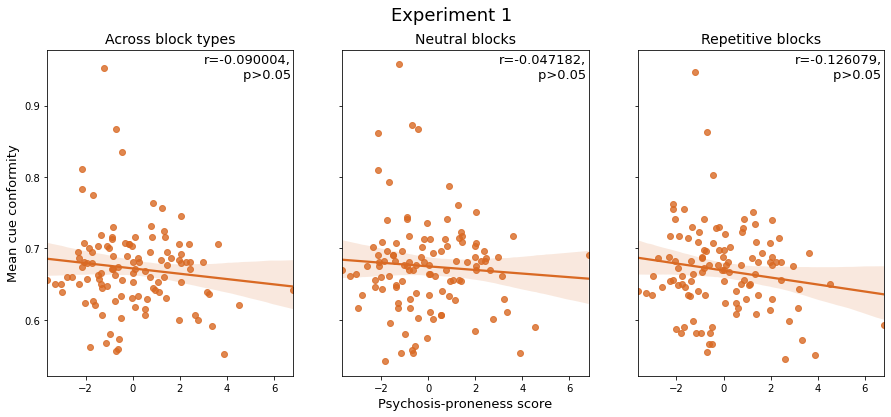

In [27]:
# create some plots on cue conformity next.

fig, axs = plt.subplots(1,3, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(15)

plt.suptitle('Experiment 1', fontsize=18)

# plot overall mean repetition probability and PPS
_=axs[0].set_title('Across block types', fontsize=14)
_=sns.regplot(ax=axs[0], x=df_rep['PPS_sum'], y=df_rep['cue_conf'], color='#D96923')
_=plt.text(0.99, 0.99, ('r=%f,\n p>0.05'%pc_allBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[0].transAxes, fontsize=13)
_=axs[0].set_ylabel('Mean cue conformity', fontsize=13)
_=axs[0].set_xlabel(None)

# plot neutral mean repetition probability and PPS
_=axs[1].set_title('Neutral blocks', fontsize=14)
_=sns.regplot(ax=axs[1], x=df_rep['PPS_sum'], y=df_rep['cue_conf_neut'], color='#D96923')
_=plt.text(0.99, 0.99, ('r=%f,\n p>0.05'%pc_neutBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[1].transAxes, fontsize=13)
_=axs[1].set_xlabel('Psychosis-proneness score', fontsize=13)
_=axs[1].set_ylabel(None)

# plot repetitive repetition probability and PPS
_=axs[2].set_title('Repetitive blocks', fontsize=14)
_=sns.regplot(ax=axs[2], x=df_rep['PPS_sum'], y=df_rep['cue_conf_rep'], color='#D96923')
_=plt.text(0.99, 0.99, ('r=%f,\n p>0.05'%pc_repBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[2].transAxes, fontsize=13)
_=axs[2].set_xlabel(None)
_=axs[2].set_ylabel(None)

plt.savefig('cue_conf_exp1.svg')